In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings, gc
warnings.filterwarnings('ignore')

from datetime import datetime

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.seasonal import seasonal_decompose

from prophet import Prophet

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.width', 1000)

In [3]:
data = pd.read_csv('cloud_cost_data')

In [4]:
data.head()

,Date,MeterCategory,CostInBillingCurrency,MeterSubCategory,MeterName,ConsumedService,ResourceLocation
0,2022-12-31,Azure App Service,0.000000,Free Plan,F1 App,microsoft.web,westeurope
1,2022-12-31,Load Balancer,0.018600,Standard,Standard Included LB Rules and Outbound Rules,Microsoft.MachineLearningServices,westeurope
2,2022-12-31,Storage,0.000004,Tables,GRS Data Stored,Microsoft.Storage,northeurope
3,2022-12-31,Load Balancer,0.018600,Standard,Standard Included LB Rules and Outbound Rules,Microsoft.MachineLearningServices,westeurope
4,2022-12-31,Storage,0.014312,Standard SSD Managed Disks,E2 Disks,Microsoft.Compute,northeurope


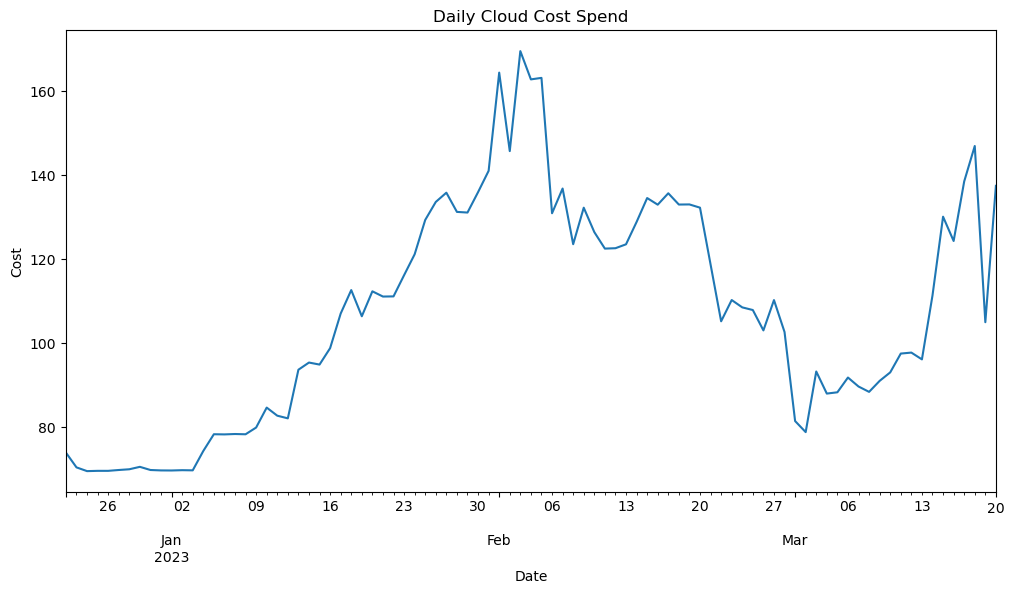

In [5]:
data['Date'] = pd.to_datetime(data['Date'])

# Set 'UsageDateTime' as the DataFrame index for time series analysis
data.set_index('Date', inplace=True)


plt.figure(figsize=(12, 6))
data['CostInBillingCurrency'].resample('D').sum().plot()  # Resampling on daily basis and summing the costs
plt.title('Daily Cloud Cost Spend')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.show()

In [6]:
daily_costs = data['CostInBillingCurrency'].resample('D').sum()
daily_costs_df = pd.DataFrame({'TotalCost': daily_costs})

print(daily_costs_df)

             TotalCost
Date                  
2022-12-22   73.960324
2022-12-23   70.439995
2022-12-24   69.546379
2022-12-25   69.612501
2022-12-26   69.613152
2022-12-27   69.814007
2022-12-28   69.986855
2022-12-29   70.567365
2022-12-30   69.813404
2022-12-31   69.714191
2023-01-01   69.697297
2023-01-02   69.769933
2023-01-03   69.730614
2023-01-04   74.341606
2023-01-05   78.334315
2023-01-06   78.295045
2023-01-07   78.387020
2023-01-08   78.323589
2023-01-09   79.929678
2023-01-10   84.681714
2023-01-11   82.753801
2023-01-12   82.117846
2023-01-13   93.701626
2023-01-14   95.412436
2023-01-15   94.930363
2023-01-16   98.840634
2023-01-17  107.083088
2023-01-18  112.677120
2023-01-19  106.437543
2023-01-20  112.382241
2023-01-21  111.135980
2023-01-22  111.175651
2023-01-23  116.227086
2023-01-24  121.210886
2023-01-25  129.388512
2023-01-26  133.679534
2023-01-27  135.882635
2023-01-28  131.303666
2023-01-29  131.149656
2023-01-30  136.010451
2023-01-31  141.088836
2023-02-01 

In [7]:
df = daily_costs_df.reset_index()[['Date','TotalCost']].rename({'Date':'ds','TotalCost':'y'},axis='columns')

In [8]:
df

,ds,y
0,2022-12-22,73.960324
1,2022-12-23,70.439995
2,2022-12-24,69.546379
3,2022-12-25,69.612501
4,2022-12-26,69.613152
5,2022-12-27,69.814007
6,2022-12-28,69.986855
7,2022-12-29,70.567365
8,2022-12-30,69.813404
9,2022-12-31,69.714191


In [9]:
train = df[(df['ds']>='2022-12-22') & (df['ds']<= '2023-03-13')]
test = df[(df['ds']> '2023-03-13')]            #7th march

In [10]:
print('Length of Train data :',len(train))
print('Length of test data :',len(test))

Length of Train data : 82
Length of test data : 7


In [11]:
train


,ds,y
0,2022-12-22,73.960324
1,2022-12-23,70.439995
2,2022-12-24,69.546379
3,2022-12-25,69.612501
4,2022-12-26,69.613152
5,2022-12-27,69.814007
6,2022-12-28,69.986855
7,2022-12-29,70.567365
8,2022-12-30,69.813404
9,2022-12-31,69.714191


In [19]:
m = Prophet(interval_width=0.95)

In [20]:
m.fit(train)

08:21:10 - cmdstanpy - INFO - Chain [1] start processing
08:21:11 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
future = m.make_future_dataframe(periods=0,freq='D')
future

,ds
0,2022-12-22
1,2022-12-23
2,2022-12-24
3,2022-12-25
4,2022-12-26
5,2022-12-27
6,2022-12-28
7,2022-12-29
8,2022-12-30
9,2022-12-31


In [22]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2022-12-22,55.072166,36.458965,73.795938
1,2022-12-23,60.767584,40.931707,80.633510
2,2022-12-24,60.576638,41.332252,80.851798
3,2022-12-25,61.954846,43.771289,81.026302
4,2022-12-26,63.080369,44.377823,81.583722
5,2022-12-27,64.665988,46.745993,84.244537
6,2022-12-28,65.930695,45.703361,84.493235
7,2022-12-29,68.824412,50.625980,88.456233
8,2022-12-30,74.519830,55.100313,93.021990
9,2022-12-31,74.328884,55.721838,92.698185


In [23]:
results = pd.concat([df.set_index('ds')['y'],forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]],axis=1)

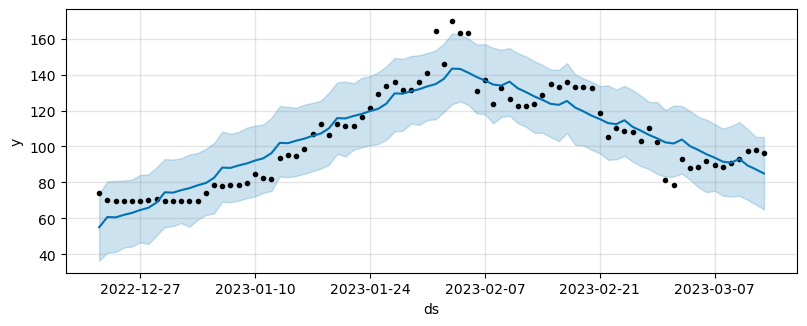

In [24]:
fig1 = m.plot(forecast)
fig1.set_size_inches(8, 3)

In [25]:
results

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2022-12-22,73.960324,55.072166,36.458965,73.795938
2022-12-23,70.439995,60.767584,40.931707,80.633510
2022-12-24,69.546379,60.576638,41.332252,80.851798
2022-12-25,69.612501,61.954846,43.771289,81.026302
2022-12-26,69.613152,63.080369,44.377823,81.583722
2022-12-27,69.814007,64.665988,46.745993,84.244537
2022-12-28,69.986855,65.930695,45.703361,84.493235
2022-12-29,70.567365,68.824412,50.625980,88.456233
2022-12-30,69.813404,74.519830,55.100313,93.021990


In [26]:
mae = mean_absolute_error(results['y'][:82], results['yhat'][:82])
mae

7.985836737126228

In [27]:
mape = mean_absolute_percentage_error(results['y'][:82], results['yhat'][:82])
mape

0.07895183338511264

In [28]:
mse = mean_squared_error(results['y'][:82], results['yhat'][:82])
mse

97.81398427240768

In [29]:
m_test = Prophet(interval_width=0.95)

In [30]:
m_test.fit(test)

08:21:11 - cmdstanpy - INFO - Chain [1] start processing
08:21:11 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
future = m_test.make_future_dataframe(periods=0,freq='D')
future

,ds
0,2023-03-14
1,2023-03-15
2,2023-03-16
3,2023-03-17
4,2023-03-18
5,2023-03-19
6,2023-03-20


In [32]:
forecast_test = m_test.predict(future)
forecast_test[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2023-03-14,122.287445,96.072076,148.959356
1,2023-03-15,124.098528,97.791412,148.991940
2,2023-03-16,125.909612,100.558041,151.734338
3,2023-03-17,127.720696,103.526933,154.851665
4,2023-03-18,129.531780,101.768262,156.093975
5,2023-03-19,131.342863,105.326898,157.564274
6,2023-03-20,133.153947,108.083110,158.476329


In [33]:
results_test = pd.concat([df.set_index('ds')['y'][82:89],forecast_test.set_index('ds')[['yhat','yhat_lower','yhat_upper']]],axis=1)

In [34]:
results_test

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2023-03-14,111.392723,122.287445,96.072076,148.959356
2023-03-15,130.164057,124.098528,97.791412,148.991940
2023-03-16,124.372183,125.909612,100.558041,151.734338
2023-03-17,138.567702,127.720696,103.526933,154.851665
2023-03-18,147.010317,129.531780,101.768262,156.093975
2023-03-19,105.024077,131.342863,105.326898,157.564274
2023-03-20,137.515357,133.153947,108.083110,158.476329


In [35]:
mae_test = mean_absolute_error(results_test['y'], results_test['yhat'])
mae_test

11.071916982646295

In [38]:
mape_test = mean_absolute_percentage_error(results_test['y'], results_test['yhat'])
mape_test *100

9.089306000365642

In [37]:
mse_test = mean_squared_error(results_test['y'], results_test['yhat'])
mse_test

184.67235869749496